#**Improving Liquor Profits of the Iowa Alcoholic Beverage Division.**

**Team Members:** Mohammed Alqenae, Luke Hong, Geech Huot, Carmen Cheung, Jennifer Horita, Mengxin Li

The state of Iowa is one of 17 “liquor controlled” states which means the government agencies have a monopoly on the wholesale business of liquor. The Iowa Alcoholic Beverage Division controls all sales of liquor including the amount distributed, wholesale price, and cost from national vendors within Iowa. While the Iowa Alcoholic Beverage Division could increase profit by simply increasing the quantity distributed, as a government entity, they are invested in regulating the volume sold throughout the state in pursuit of public wellness. We plan to analyze the distribution of liquor by the Iowa Alcoholic Beverage Division data to optimize profit while also limiting the volume of liquor sold to stores across Iowa. 

**Data Source:**  State of Iowa's Alcoholic Beverages Division of the Iowa Department of Commerce 

https://console.cloud.google.com/marketplace/product/iowa-department-of-commerce/iowa-liquor-sales
https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy

The dataset includes every transaction of liquor sold in the State of Iowa by the Iowa Alcoholic Beverage Division to stores since January 1, 2012. The dataset is composed of invoice/order of each item of liquor by retailer with information about the stores and the liquor (brand, category, item, volume,cost, retail price etc.)






In [ ]:
from google.colab import auth
auth.authenticate_user()

### **Overview of Data Sample**

In [ ]:
#First few rows of data
%%bigquery --project=ba775-team4-b2
select * from `bigquery-public-data.iowa_liquor_sales.sales` limit 5

invoice_and_item_number        date  ... volume_sold_liters volume_sold_gallons
0            S27907500018  2015-10-13  ...               27.0                7.13
1            S20667500021  2014-08-14  ...               22.5                5.94
2            S27635800041  2015-09-01  ...               27.0                7.13
3            S12405700025  2013-05-23  ...              180.0               47.55
4            S09778400041  2012-12-28  ...               60.0               15.85

[5 rows x 24 columns]

## **Trend Analysis**

---


From an analysis of year to year trends from 2012-2020, the liters of liquor sold to profit ratio has been decreasing which means that Iowa is achieving the same or more profit while distributing the same less liquor volume at the wholesale level. Our primary objective is to achieve to maximize profit while minimizing the necessity to distribute more liquor. This liters of liquor sold to profit ratio will be used as a measure of the effectiveness of our recommendations where a lower ratio means more profit at the same volume of liquor sold. 

In [ ]:
%%bigquery --project=ba775-team4-b2
## What are the year to year trends?
select distinct extract(year from date) as year, sum(volume_sold_liters) as liters_sold, sum(sale_dollars) as revenue, SUM((state_bottle_retail-state_bottle_cost)*bottles_sold) AS profit_dollars,
(sum(volume_sold_liters)/sum(sale_dollars)) AS liters_sold_to_revenue_ratio,(sum(volume_sold_liters)/SUM((state_bottle_retail-state_bottle_cost)*bottles_sold)) AS liters_sold_to_profit_ratio, 
avg(((state_bottle_retail - state_bottle_cost)/state_bottle_retail*100)) as avg_pm_per_bottle_percent, avg((state_bottle_retail-state_bottle_cost)/(bottle_volume_ml)) AS  avg_profit_per_ml
from bigquery-public-data.iowa_liquor_sales.sales
where item_number is not null
  and state_bottle_retail != 0
  and bottles_sold != 0
  and bottle_volume_ml != 0
group by year
order by year desc;

year   liters_sold  ...  avg_pm_per_bottle_percent  avg_profit_per_ml
0  2020  2.028373e+07  ...                  33.349975           0.016196
1  2019  1.500590e+07  ...                  33.346550           0.007932
2  2018  2.189598e+07  ...                  33.347439           0.006585
3  2017  2.109685e+07  ...                  33.347808           0.006332
4  2016  2.030026e+07  ...                  33.375420           0.006173
5  2015  1.961770e+07  ...                  33.430169           0.006051
6  2014  1.915761e+07  ...                  33.476231           0.005889
7  2013  1.857637e+07  ...                  33.521257           0.005724
8  2012  1.873839e+07  ...                  33.533574           0.005553

[9 rows x 8 columns]

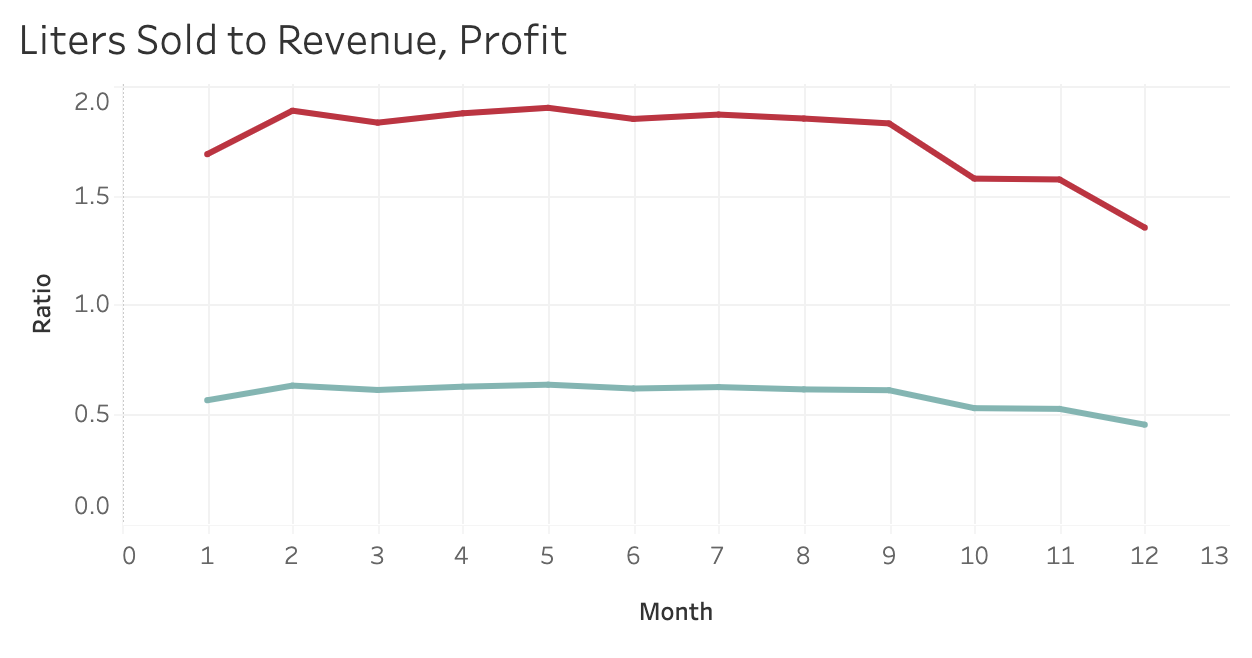
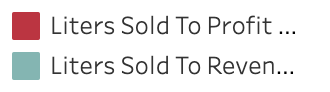

## **1. Liquor Demand**

### **1a.** What is the most demanded type of liquor?  

After conducting analysis on the different liquor categories, we found that, in terms of revenue, whiskies, vodkas, and rum were most popular.

In [ ]:
%%bigquery --project=ba775-team4-b2
## What is the most demanded type of liquor?
select distinct category, upper(category_name) as category_name, sum(sale_dollars) as total_rev
from `bigquery-public-data.iowa_liquor_sales.sales`
where category is not null and category_name is not null and sale_dollars is not null
group by category, category_name
order by total_rev desc LIMIT 10;

category              category_name     total_rev
0  1012100          CANADIAN WHISKIES  3.106382e+08
1  1031100            AMERICAN VODKAS  1.927807e+08
2  1011200  STRAIGHT BOURBON WHISKIES  1.518297e+08
3  1031080             VODKA 80 PROOF  1.457649e+08
4  1081600            WHISKEY LIQUEUR  1.234124e+08
5  1062310                 SPICED RUM  9.970825e+07
6  1062400                 SPICED RUM  8.632387e+07
7  1032080             IMPORTED VODKA  7.644585e+07
8  1011100           BLENDED WHISKIES  7.324055e+07
9  1022100                    TEQUILA  6.847920e+07

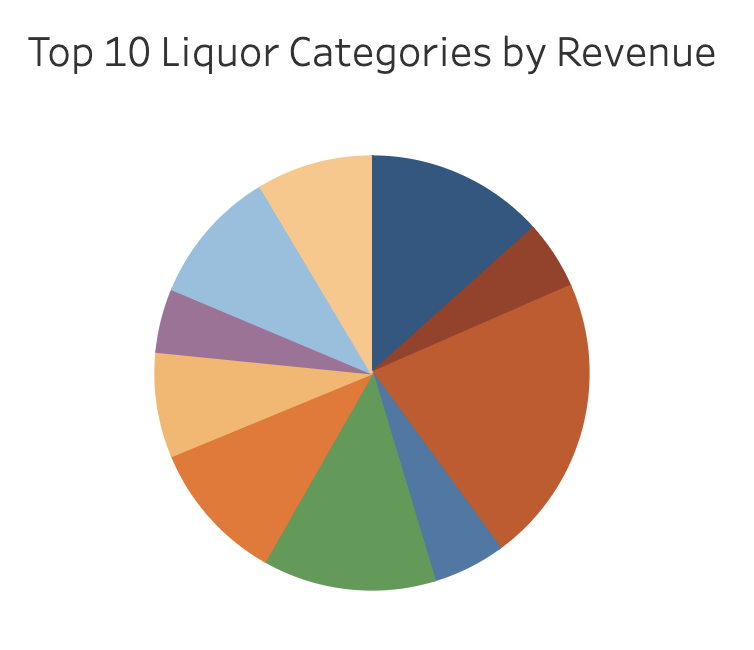
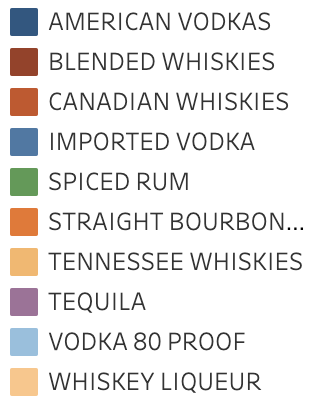

### **1b.** Which item had the highest demand in terms of bottles sold?

Black Velvet Whiskey was the highest demanded item in terms of bottles sold. Although bottles sold is a decent measure of popularity, we found that liters sold is a better measure for the quantity as the volume of the bottles is not consistent throughout the items.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which item had the highest demand in terms of bottles sold?
select distinct upper(item_description) as description, sum(bottles_sold) as bottles_sold
from `bigquery-public-data.iowa_liquor_sales.sales`
where item_description is not null
group by description
order by bottles_sold desc LIMIT 10;

description  bottles_sold
0                   BLACK VELVET       9728545
1                  HAWKEYE VODKA       6962406
2      FIREBALL CINNAMON WHISKEY       5427486
3             FIVE O'CLOCK VODKA       4336055
4      CAPTAIN MORGAN SPICED RUM       4139085
5              FIREBALL CINNAMON       3512310
6           TITOS HANDMADE VODKA       3507704
7            MCCORMICK VODKA PET       3028017
8                   BARTON VODKA       2841809
9  JACK DANIELS OLD #7 BLACK LBL       2606869

### **1c.** Which item was the most popular each year?

The most popular items for each year were high end brands like Remy Martin or items sold in large volumes like barrels.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which item was the most popular each year?
WITH a as (
select extract(year from date) as year, item_number, lower(item_description) as description, avg(sale_dollars/volume_sold_liters) as avg_rev_per_liter
from `bigquery-public-data.iowa_liquor_sales.sales`
where item_number is not null and volume_sold_liters != 0
group by year, item_number, description
order by year desc),

b as(
select a.*, rank() over (partition by year order by avg_rev_per_liter desc) rn 
from a
order by year desc)

select * from b
where rn = 1 LIMIT 10;

year item_number  ... avg_rev_per_liter  rn
0  2020      948723  ...       9741.000000   1
1  2019       48725  ...       3398.288889   1
2  2018      994807  ...       3742.400000   1
3  2017      903056  ...       2898.520000   1
4  2016      927849  ...      15360.000000   1
5  2015      987086  ...      12000.000000   1
6  2015      987085  ...      12000.000000   1
7  2015      987084  ...      12000.000000   1
8  2015      987087  ...      12000.000000   1
9  2014      927368  ...      11600.000000   1

[10 rows x 5 columns]

### **1d.** Which month in the year has the most liquor sales? 

June had the most liquor sales by bottled_sold and liters_sold. By looking at the seasonality of the most liquor sales, vendors can predict and time inventories more efficiently.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which month in the year has the most liquor sales?
select extract(month from date) as month, sum(bottles_sold) as bottles_sold, sum(volume_sold_liters) as liters_sold
FROM `bigquery-public-data.iowa_liquor_sales.sales`
where bottles_sold is not null and volume_sold_liters is not null and date is not null
group by month
order by bottles_sold desc, liters_sold desc;

month  bottles_sold   liters_sold
0       6      18553982  1.653297e+07
1       5      18336945  1.661799e+07
2      10      18085618  1.627451e+07
3       8      17878815  1.563070e+07
4       7      17602272  1.558740e+07
5       4      17055667  1.519586e+07
6       3      16175419  1.407565e+07
7      12      15494854  1.373248e+07
8       9      15204680  1.355576e+07
9       2      15090154  1.370638e+07
10     11      14802124  1.271375e+07
11      1      12583691  1.106633e+07

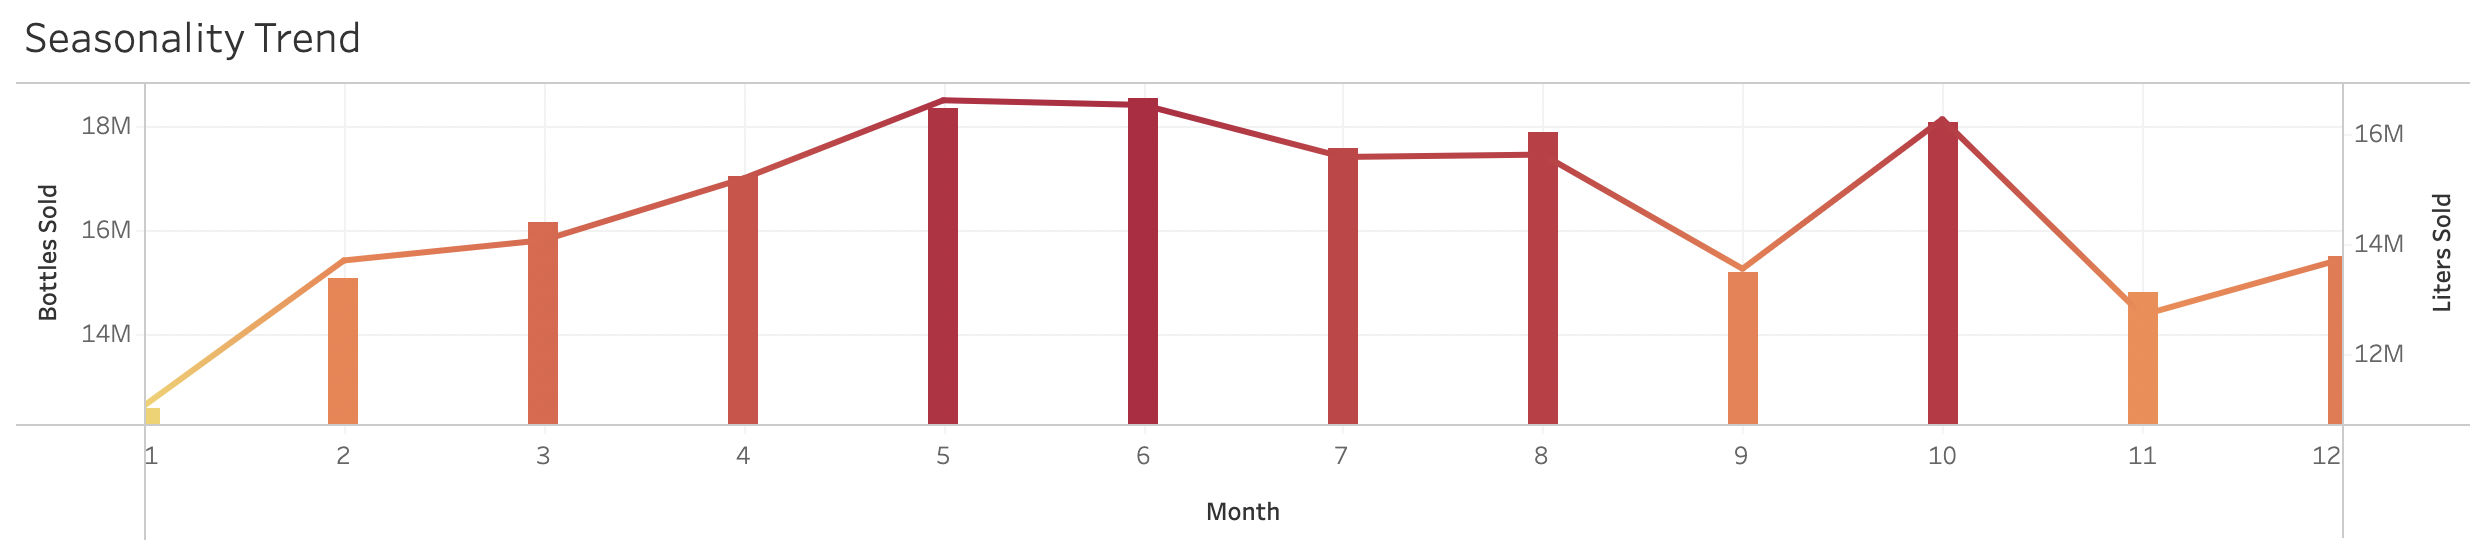

## **2. Revenue Analysis**

---

### **2a.** Which items have the highest revenue?

Black Velvet Whiskey had the highest revenue_per_item. By looking at revenue, we can measure the sales of each item.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which items have the highest revenue?
SELECT distinct item_number,item_description,SUM(sale_dollars) AS revenue_per_item 
FROM bigquery-public-data.iowa_liquor_sales.sales
where item_number is not null
GROUP BY item_number,item_description
ORDER BY revenue_per_item DESC LIMIT 10;

item_number               item_description  revenue_per_item
0       11788                   Black Velvet      7.232972e+07
1       43337      Captain Morgan Spiced Rum      4.431236e+07
2       26827  Jack Daniels Old #7 Black Lbl      3.159004e+07
3       11297    Crown Royal Canadian Whisky      2.946401e+07
4       36308                  Hawkeye Vodka      2.915975e+07
5       11296                    Crown Royal      2.828199e+07
6       38178           Titos Handmade Vodka      2.643765e+07
7       38177           Titos Handmade Vodka      2.427756e+07
8       43338      Captain Morgan Spiced Rum      2.307597e+07
9       64867      Fireball Cinnamon Whiskey      2.042885e+07

### **2b.** Which items had the most liters sold? total revenue for those items?

Our analysis showed us that although revenue is an important measure to analyze when looking at demand, it is also important to understand which items are most popular in terms of the volume being sold.
We found that some items that may have had higher revenues were not as high in liters sold. This could be due to higher prices in luxury brand items.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which items had the most liters sold? total revenue for those items?
SELECT distinct upper(item_description) as description, sum(volume_sold_liters) as liters_sold, sum(sale_dollars) as total_rev
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
where sale_dollars is not null
GROUP BY description
ORDER BY liters_sold desc, total_rev desc LIMIT 10;

description  liters_sold     total_rev
0                   BLACK VELVET  11202883.76  1.039413e+08
1                  HAWKEYE VODKA   7640152.50  4.841533e+07
2      CAPTAIN MORGAN SPICED RUM   4322006.92  7.287293e+07
3             FIVE O'CLOCK VODKA   3988103.14  2.578416e+07
4           TITOS HANDMADE VODKA   3804379.45  6.773956e+07
5      FIREBALL CINNAMON WHISKEY   3457641.21  5.592234e+07
6                   BARTON VODKA   3303387.69  1.979086e+07
7  JACK DANIELS OLD #7 BLACK LBL   2467194.00  6.726271e+07
8                 PHILLIPS VODKA   2432674.42  1.578997e+07
9      ADMIRAL NELSON SPICED RUM   2074917.94  2.163445e+07

## **3. Profit Analysis**

### **3a.** Which items have the highest overall profit and what is their profit per bottle? 

These are the items that contribute the most to the overall profit of the Iowa Alcoholic Beverage Division along with the profit per bottle that each liquor brings. Similar to revenue, Black Velvet Whiskey also contributes the most to the overall profit.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which items have the highest overall profit and what is their profit per bottle?  
SELECT distinct item_number,item_description, SUM((state_bottle_retail-state_bottle_cost)*bottles_sold) AS profit, AVG(state_bottle_retail - state_bottle_cost) AS profit_per_bottle 
FROM bigquery-public-data.iowa_liquor_sales.sales
where item_number is not null
GROUP BY item_number,item_description
ORDER BY profit DESC LIMIT 10;

item_number               item_description        profit  profit_per_bottle
0       11788                   Black Velvet  2.461025e+07           5.227137
1       43337      Captain Morgan Spiced Rum  1.476436e+07           5.828470
2       26827  Jack Daniels Old #7 Black Lbl  1.052442e+07           9.016077
3       11297    Crown Royal Canadian Whisky  9.820472e+06           9.229828
4       36308                  Hawkeye Vodka  9.725595e+06           3.586685
5       11296                    Crown Royal  9.465683e+06           7.581143
6       38178           Titos Handmade Vodka  8.859960e+06           9.447099
7       38177           Titos Handmade Vodka  8.188913e+06           6.262424
8       43338      Captain Morgan Spiced Rum  7.697651e+06           8.921484
9       64867      Fireball Cinnamon Whiskey  6.804845e+06           5.661220

### **3b.** Which items have the highest profit margin per bottle? 

Although these items have the highest profit margins, by observing the liters sold we can notice that these items don’t have much demand in terms of liters sold. Without demand for this liquor, even if we recommend increasing these liquors solely because of the higher profit margin, limited sales would hinder overall profit.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which items have the highest profit margin per bottle? 
select distinct item_number, item_description, avg(((state_bottle_retail - state_bottle_cost)/state_bottle_retail)*100) as pm_per_bottle_percent, sum(volume_sold_liters) as liters_sold
from bigquery-public-data.iowa_liquor_sales.sales
where item_number is not null
  and state_bottle_retail != 0
group by item_number, item_description
order by pm_per_bottle_percent desc, liters_sold desc LIMIT 10;

item_number  ... liters_sold
0         580  ...      216.00
1      927950  ...        4.50
2       53937  ...      260.75
3       53936  ...      218.00
4       74763  ...      357.75
5      942403  ...       94.50
6       41936  ...      516.00
7       41940  ...      833.25
8         249  ...       74.25
9       52591  ...     1602.10

[10 rows x 4 columns]

### **3c.** What are the profit margins of the items that were consumed the most in liters?

We observed the profit margins of the items that sold the most volume in liters (highest demand) and found that the bestsellers all had profit margins around 33%. At this level of analysis, we can only speculate that it is perhaps the ideal profit margin or that the government imposed regulations on the markup price or a price ceiling. With this information, instead of looking at how to change the profit by selling it at a higher price, we chose to look at making the mix of liquors that are being sold more efficient to increase profit.**

In [ ]:
%%bigquery --project=ba775-team4-b2
## What are the profit margins of the items that were consumed the most in liters?
select distinct item_number, item_description, sum(volume_sold_liters) as liters_sold, avg(((state_bottle_retail - state_bottle_cost)/state_bottle_retail)*100) as pm_per_bottle_percent
from bigquery-public-data.iowa_liquor_sales.sales
where item_number is not null
  and state_bottle_retail != 0
group by item_number, item_description
order by liters_sold desc, pm_per_bottle_percent desc LIMIT 10;


item_number           item_description  liters_sold  pm_per_bottle_percent
0       11788               Black Velvet   8239008.75              33.762995
1       36308              Hawkeye Vodka   4746108.50              33.364341
2       43337  Captain Morgan Spiced Rum   2534114.00              33.338630
3       35918         Five O'clock Vodka   1849804.25              33.317769
4       35317               Barton Vodka   1743535.00              33.351191
5       38178       Titos Handmade Vodka   1636986.75              33.333688
6       43338  Captain Morgan Spiced Rum   1509520.25              33.384725
7       35318               Barton Vodka   1403489.50              33.330193
8       37348             Phillips Vodka   1348817.75              33.337110
9       43028  Admiral Nelson Spiced Rum   1344686.00              33.342458

In [ ]:
%%bigquery --project=ba775-team4-b2
## What is the most demanded type of liquor?  
select distinct category, upper(category_name) as category_name, sum(sale_dollars) as total_rev
from `bigquery-public-data.iowa_liquor_sales.sales`
where category is not null and category_name is not null and sale_dollars is not null
group by category, category_name
order by total_rev desc LIMIT 10;

### **3d.** What is the average profit/mL ratio of each item? Which has the highest profit margin by volume?

As we analyzed the demand, the top three categories of liquors that brought in the most revenue were whisky, rum, and vodka. We grouped the best selling brands into their liquor type and found the average profit per mL for each (0.0090, 0.0057, and 0.0055 respectively). This analysis led us to conclude that the best performing liquor in demand, standardized for varying 
bottle size using profit per mL, is whisky.**

In [ ]:
%%bigquery --project=ba775-team4-b2
## What is the average profit/mL ratio of each item? Which has the highest profit margin by volume?
with a as (
select distinct category, upper(category_name) as category_name, sum(sale_dollars) as total_rev, AVG(((state_bottle_retail-state_bottle_cost)*bottles_sold)/(bottles_sold*bottle_volume_ml)) AS avg_profit_ml
from `bigquery-public-data.iowa_liquor_sales.sales`
where category is not null and category_name is not null and sale_dollars is not null and bottles_sold is not null and state_bottle_cost is not null and state_bottle_retail is not null 
and bottle_volume_ml is not null AND bottles_sold!=0 AND bottle_volume_ml!=0
group by category, category_name
order by total_rev desc LIMIT 9),

b as(
select a.*, rank() over (partition by category, category_name order by total_rev desc) rn 
from a
order by total_rev desc)

select case when category_name in ('WHISKEY LIQUEUR','STRAIGHT BOURBON WHISKIES','CANADIAN WHISKIES','BLENDED WHISKIES') THEN 'WHISKEY'
when category_name in ('TEQUILA') THEN 'TEQUILA'
when category_name in ('IMPORTED VODKA','AMERICAN VODKAS','VODKA 80 PROOF') THEN 'VODKA'
when category_name in ('SPICED RUM') THEN 'RUM'
ELSE category_name
end as category_type, 
avg(avg_profit_ml) as avg_profit_ml
from a
group by category_type
order by avg_profit_ml desc


category_type  avg_profit_ml
0       WHISKEY       0.008891
1           RUM       0.005717
2         VODKA       0.005486

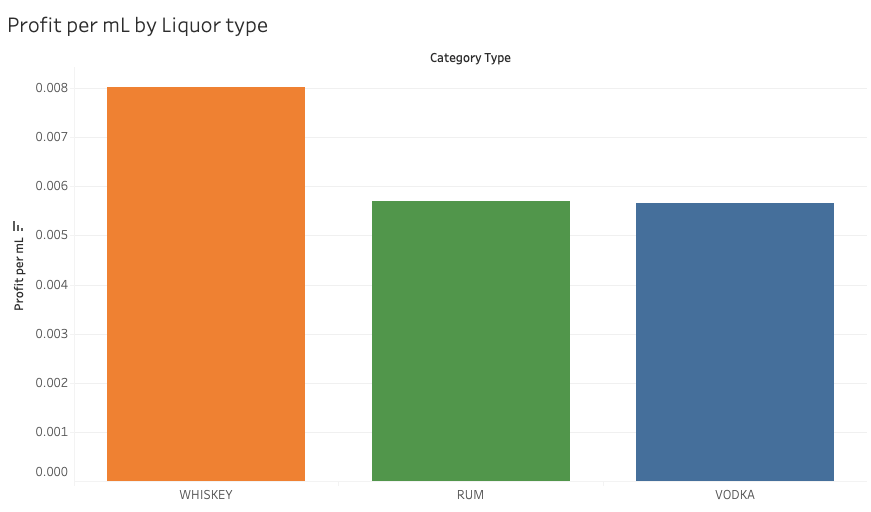

> Indented block



### **3e.** Which brands yield the highest profit per mL ratio within it’s liquor category of the top 9 best selling liquors by revenue?  

From this analysis of the best performing liquors by revenue, we looked at the profit by ml that each one brought in. Prioritizing a higher profit per mL ratio means profit is increasing while volume stays constant. Within the top selling liquor categories of whisky, vodka, and rum, the following brands performed better in its category in our analysis: 
Whisky Liqueur (1081600) amongst the most popular whiskies with a profit per mL of 0.015862
Imported Vodka (1032080) amongst the most popular vodkas with a profit per mL of 0.008269
Spiced Rum (1062400) amongst the most popular rums  with a profit per mL of 0.006227 



In [ ]:
%%bigquery --project=ba775-team4-b2
# Which brands yield the highest profit per mL ratio within it’s liquor category of the top ten best selling liquors by revenue?  
select distinct category, upper(category_name) as category_name, sum(sale_dollars) as total_rev, avg((state_bottle_retail-state_bottle_cost)/(bottle_volume_ml)) AS profit_per_ml
from `bigquery-public-data.iowa_liquor_sales.sales`
where category is not null and category_name is not null and sale_dollars is not null
and bottle_volume_ml != 0
group by category, category_name
order by total_rev desc LIMIT 9;


category              category_name     total_rev  profit_per_ml
0  1012100          CANADIAN WHISKIES  3.106381e+08       0.006862
1  1031100            AMERICAN VODKAS  1.927807e+08       0.004975
2  1011200  STRAIGHT BOURBON WHISKIES  1.518297e+08       0.008246
3  1031080             VODKA 80 PROOF  1.457649e+08       0.003214
4  1081600            WHISKEY LIQUEUR  1.234124e+08       0.015862
5  1062310                 SPICED RUM  9.970825e+07       0.005206
6  1062400                 SPICED RUM  8.632387e+07       0.006227
7  1032080             IMPORTED VODKA  7.644585e+07       0.008269
8  1011100           BLENDED WHISKIES  7.324055e+07       0.004595

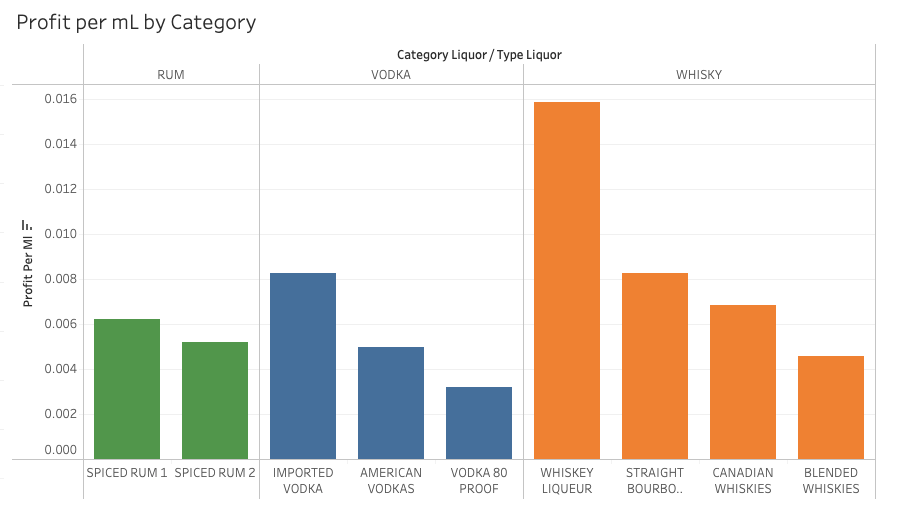

## **4. Distribution** **Analysis**
---

### **4a.** What are the vendors that supply the greatest number of stores?

In terms of distribution, we first decide to find out the most valuable vendors by finding the ones that supply the greatest number of stores. After analyzing, we observed that DIAGEO AMERICAS,JIM BEAM BRANDS, and ​​PROXIMO are the top three vendors that supply a great number of stores, with  each of them  supplying 2620,2600, 2587  respectively. 


In [ ]:
%%bigquery --project=ba775-team4-b2
## What are the vendors that supply the greatest number of stores?
SELECT upper(vendor_name) as vendors, count(distinct store_name) as stores
FROM `bigquery-public-data.iowa_liquor_sales.sales`
GROUP BY vendors
ORDER BY stores desc LIMIT 10

vendors  stores
0        DIAGEO AMERICAS    2620
1        JIM BEAM BRANDS    2600
2                PROXIMO    2587
3     HEAVEN HILL BRANDS    2585
4                MHW LTD    2458
5  SAZERAC NORTH AMERICA    2422
6   SAZERAC COMPANY  INC    2195
7     BROWN FORMAN CORP.    2181
8      PERNOD RICARD USA    2178
9        BACARDI USA INC    2172

### **4b.** Which stores sell the greatest number of bottles?

The store that sell the most liquor are Hy-Vee #3 / BDI / Des Moines with 5004198 bottles, following with second and third highest records are Central City 2 with 4076104 bottles sold and Hy-Vee Wine and Spirits/ Iowa city  2426483 bottles sold.

In [ ]:
%%bigquery --project=ba775-team4-b2
## Which stores sell the greatest number of bottles?
SELECT store_number,store_name,SUM(bottles_sold) As total_bottles_sold,
FROM bigquery-public-data.iowa_liquor_sales.sales
GROUP BY store_number,store_name
ORDER BY SUM(bottles_sold) DESC LIMIT 10

store_number                           store_name  total_bottles_sold
0         2633         Hy-Vee #3 / BDI / Des Moines             5004198
1         4829                       Central City 2             4076104
2         2512  Hy-Vee Wine and Spirits / Iowa City             2426483
3         3385       Sam's Club 8162 / Cedar Rapids             1909129
4         3420    Sam's Club 6344 / Windsor Heights             1697007
5         3952                        Lot-A-Spirits             1456190
6         2190            Central City Liquor, Inc.             1330431
7         3354          Sam's Club 8238 / Davenport             1239323
8         3773                    Benz Distributing             1200527
9         5102                       Wilkie Liquors             1082826

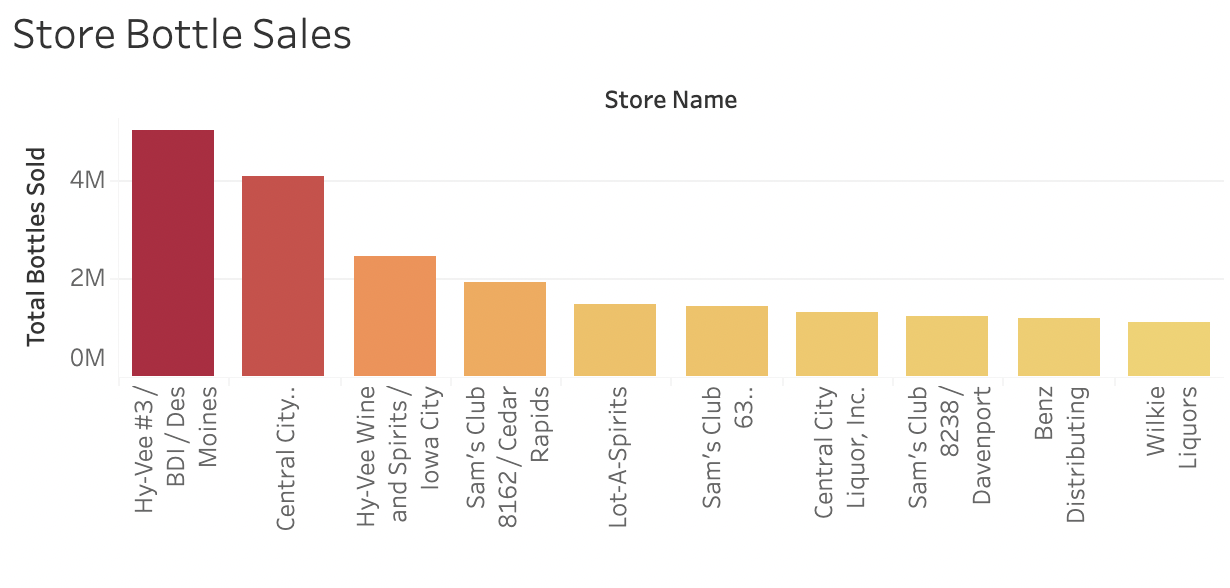

### **4c.** What are the vendors  that had the most liquor sold in terms of  volume?

The top three vendors with the most liquor sold in term of volume are DIAGEO AMERICAS, LUXCO-ST LOUIS and LUXCO INC.


In [ ]:
%%bigquery --project=ba775-team4-b2
## the vendors that sold the most volume of liquor
SELECT vendor_number, upper(vendor_name) as vendor_name , SUM(volume_sold_liters) As total_volume_sold,
FROM bigquery-public-data.iowa_liquor_sales.sales
GROUP BY vendor_number, vendor_name
ORDER BY total_volume_sold DESC LIMIT 10

vendor_number                       vendor_name  total_volume_sold
0           260                   DIAGEO AMERICAS       2.761466e+07
1           434                    LUXCO-ST LOUIS       1.178889e+07
2           434                         LUXCO INC       8.671857e+06
3           421              SAZERAC COMPANY  INC       8.257160e+06
4           115  CONSTELLATION WINE COMPANY, INC.       7.706743e+06
5            65                   JIM BEAM BRANDS       7.291771e+06
6           259                HEAVEN HILL BRANDS       6.990078e+06
7            55             SAZERAC NORTH AMERICA       6.582813e+06
8           115          CONSTELLATION BRANDS INC       6.321400e+06
9           065                   JIM BEAM BRANDS       6.274365e+06

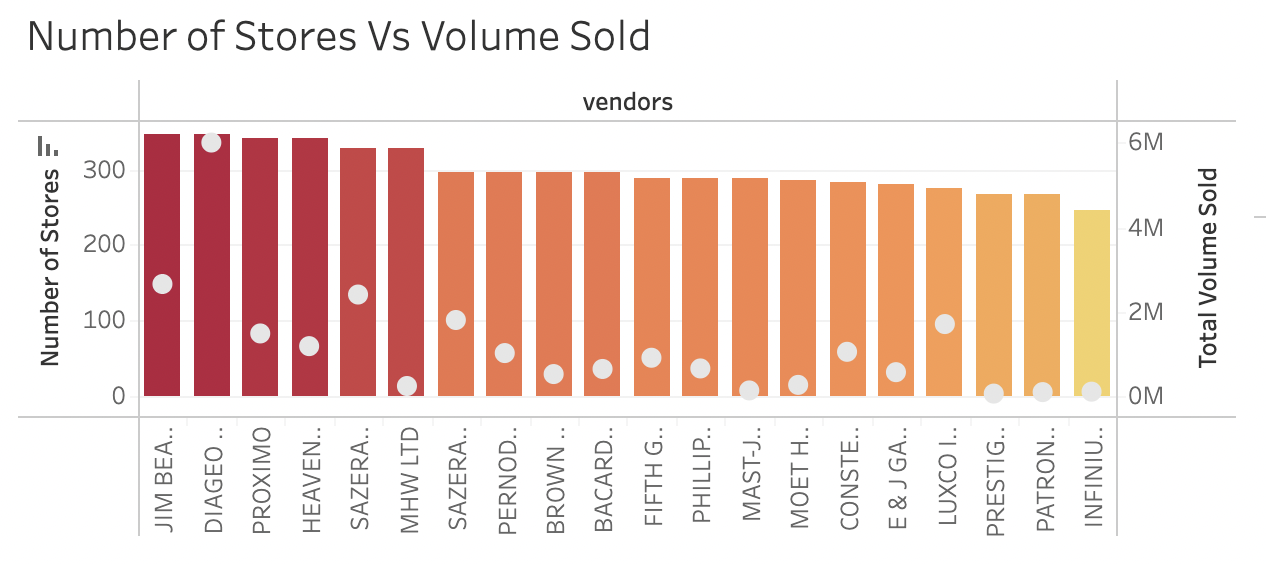

 
The conclusion that we get from question 13 and 15 is that the largest supplier/ vendor to the stores is not the same in terms of the volume sold because they might supply to many stores but each store might not buy a lot in terms of volume from the vendors. Iowa's government should focus more on supporting vendors with the most volume sold instead of the number of stores they supplied. 



### **4d.** Observing the vendors by counties by the highest revenue and profit.

Polk, Iowa is the county with highest revenue and profits due to having alot of vendors locating there. The largest supplier of liquor in the county is DIAGEO AMERICAS compare to its competitors in the the counties. 

In [ ]:
%%bigquery --project=ba775-team4-b2
## top 100 vendors and the county with highest revenue and profit. 
with a as (

SELECT vendor_number, upper(vendor_name) as vendors, upper(county) as county, sale_dollars, state_bottle_retail,state_bottle_cost,bottles_sold,
    case when substring(vendor_number,1,1) = '0' then SUBSTRING(vendor_number, 2, 4)
    else vendor_number end as vendor_number_1
FROM `bigquery-public-data.iowa_liquor_sales.sales`
where vendor_name is not null and sale_dollars is not null and state_bottle_retail is not null and state_bottle_cost is not null
and bottles_sold is not null and county is not null)

select distinct vendor_number_1,county, SUM(sale_dollars) AS revenue, 
    SUM((state_bottle_retail-state_bottle_cost)*bottles_sold) AS profit,
    case when vendors in ('BACARDI U.S.A., INC.','BACARDI USA INC') then 'BACARDI USA INC'
        when vendors in ('BROWN FORMAN CORP.','BROWN-FORMAN CORPORATION') then 'BROWN-FORMAN CORPORATION'
        when vendors in ('CONSTELLATION WINE COMPANY, INC.','CONSTELLATION BRANDS INC') then 'CONSTELLATION BRANDS INC'
        when vendors in ('E & J GALLO WINERY','E AND J GALLO WINERY') then 'E AND J GALLO WINERY'
        when vendors in ('PERNOD RICARD USA','PERNOD RICARD USA/AUSTIN NICHOLS') then 'PERNOD RICARD USA'
        when vendors in ('PHILLIPS BEVERAGE','PHILLIPS BEVERAGE COMPANY') then 'PHILLIPS BEVERAGE COMPANY'
        when vendors in ('THE PATRON SPIRITS COMPANY','THE PATRON SPIRITS COMPANY') then 'THE PATRON SPIRITS COMPANY'
        when vendors in ('MOET HENNESSY USA, INC.','MOET HENNESSY USA') then 'MOET HENNESSY USA'
        when vendors in ('SAZERAC COMPANY  INC','SAZERAC CO., INC.') then 'SAZERAC COMPANY  INC'
        when vendors in ('LUXCO-ST LOUIS','LUXCO INC') then 'LUXCO INC'
        else vendors
        end as vendors_name  
from a
GROUP BY vendor_number_1, vendors_name, county
ORDER BY revenue DESC, profit desc
limit 100

vendor_number_1         county  ...        profit            vendors_name
0              260           POLK  ...  4.203868e+07         DIAGEO AMERICAS
1              370           POLK  ...  1.529388e+07       PERNOD RICARD USA
2              260           LINN  ...  1.487177e+07         DIAGEO AMERICAS
3               65           POLK  ...  1.437255e+07         JIM BEAM BRANDS
4              421           POLK  ...  1.372673e+07    SAZERAC COMPANY  INC
..             ...            ...  ...           ...                     ...
95              65  POTTAWATTAMIE  ...  1.581405e+06         JIM BEAM BRANDS
96             410           POLK  ...  1.585036e+06  PATRON SPIRITS COMPANY
97             301          SCOTT  ...  1.552420e+06    FIFTH GENERATION INC
98             205     BLACK HAWK  ...  1.534971e+06    E AND J GALLO WINERY
99             370         DALLAS  ...  1.513972e+06       PERNOD RICARD USA

[100 rows x 5 columns]

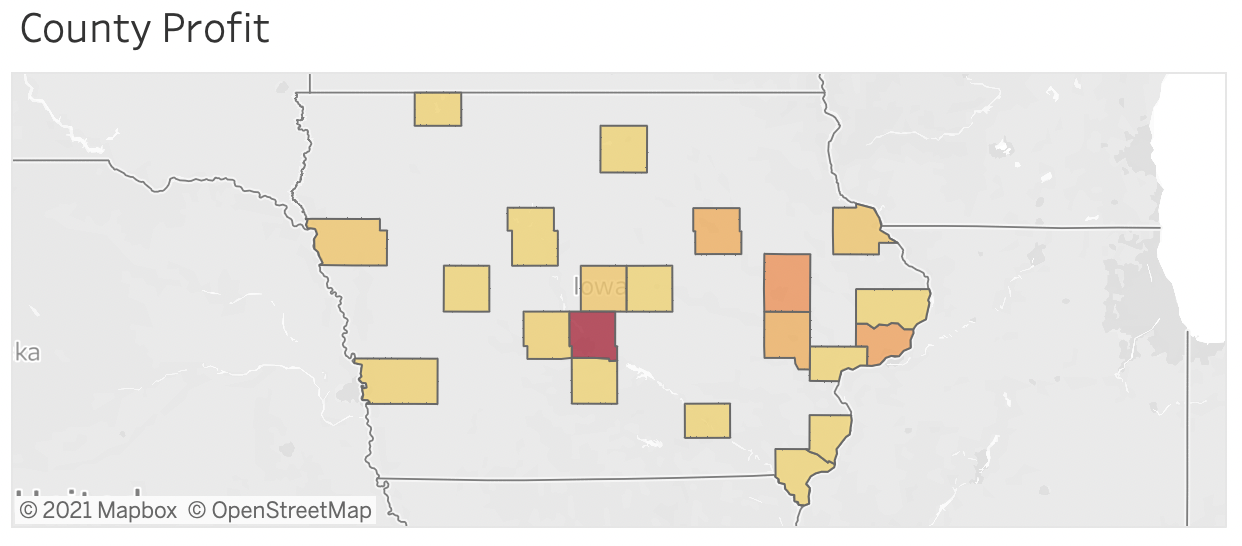

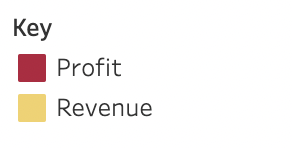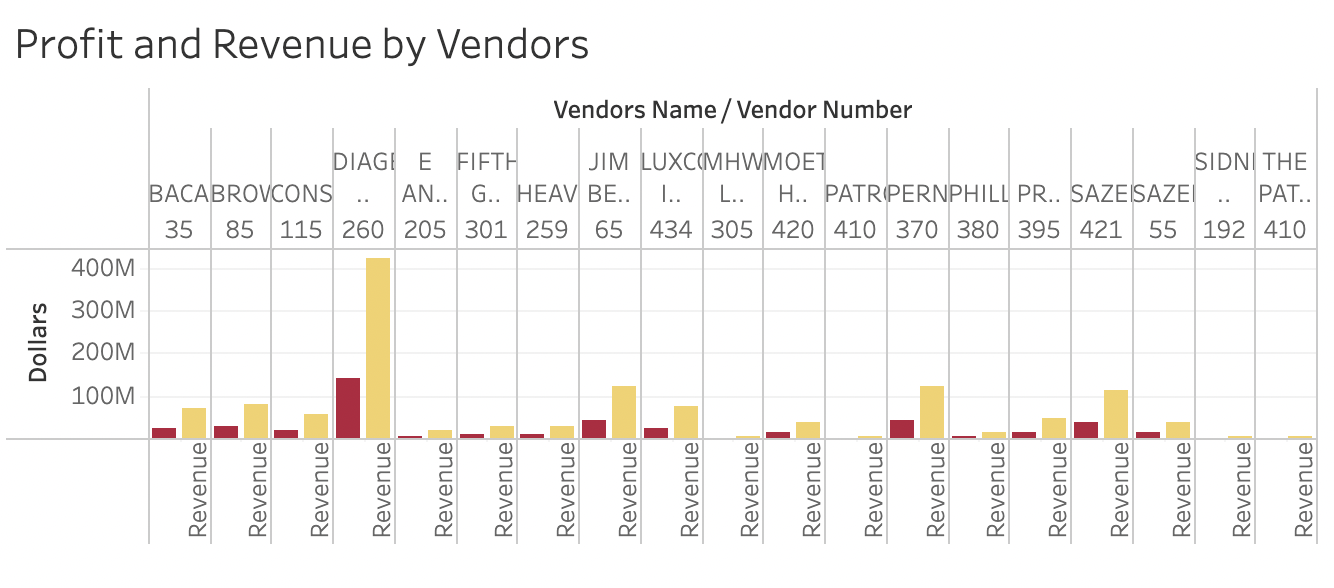

## **Conclusion**
---

In our analysis of liquor demand, revenue, profit, and vendor relationships, we report the following findings that are aimed towards achieving our goal of maximizing profit while limiting the volume of liquor distributed throughout Iowa (supporting data in each query):
 
*   Amongst the best selling liquors, the liquor categories that they belonged ton were whisky, vodka, and rum with whisky having the highest profit per mL ratio. Promoting the sale of whisky over the sale of vodka or rum would increase profit for the same volume of liquor distributed. The effect of this recommendation on the profit and liters sold to profit ratio is shown below at each percentage of the current volume sold is replaced with our recommended liquor type. 

*   Within the most demanded liquor types, the following had the highest profit per mL amongst competing brands: Whisky Liqueur (1081600) for whisky, Imported Vodka (1032080) for vodka, and Spiced Rum (1062400) for the rum category. Promoting these brands over other popular liquors increases the average profit per volume ratio. The effect of this recommendation on the profit and liters sold to profit ratio is shown below at each percentage of the current volume sold is replaced with our recommended category within the liquor type. 

*   The vendors that sell to the greatest number of stores don’t necessarily sell the greatest number of bottles, focusing on vendors that sell the greatest number of bottles can minimize distribution costs by consolidating.


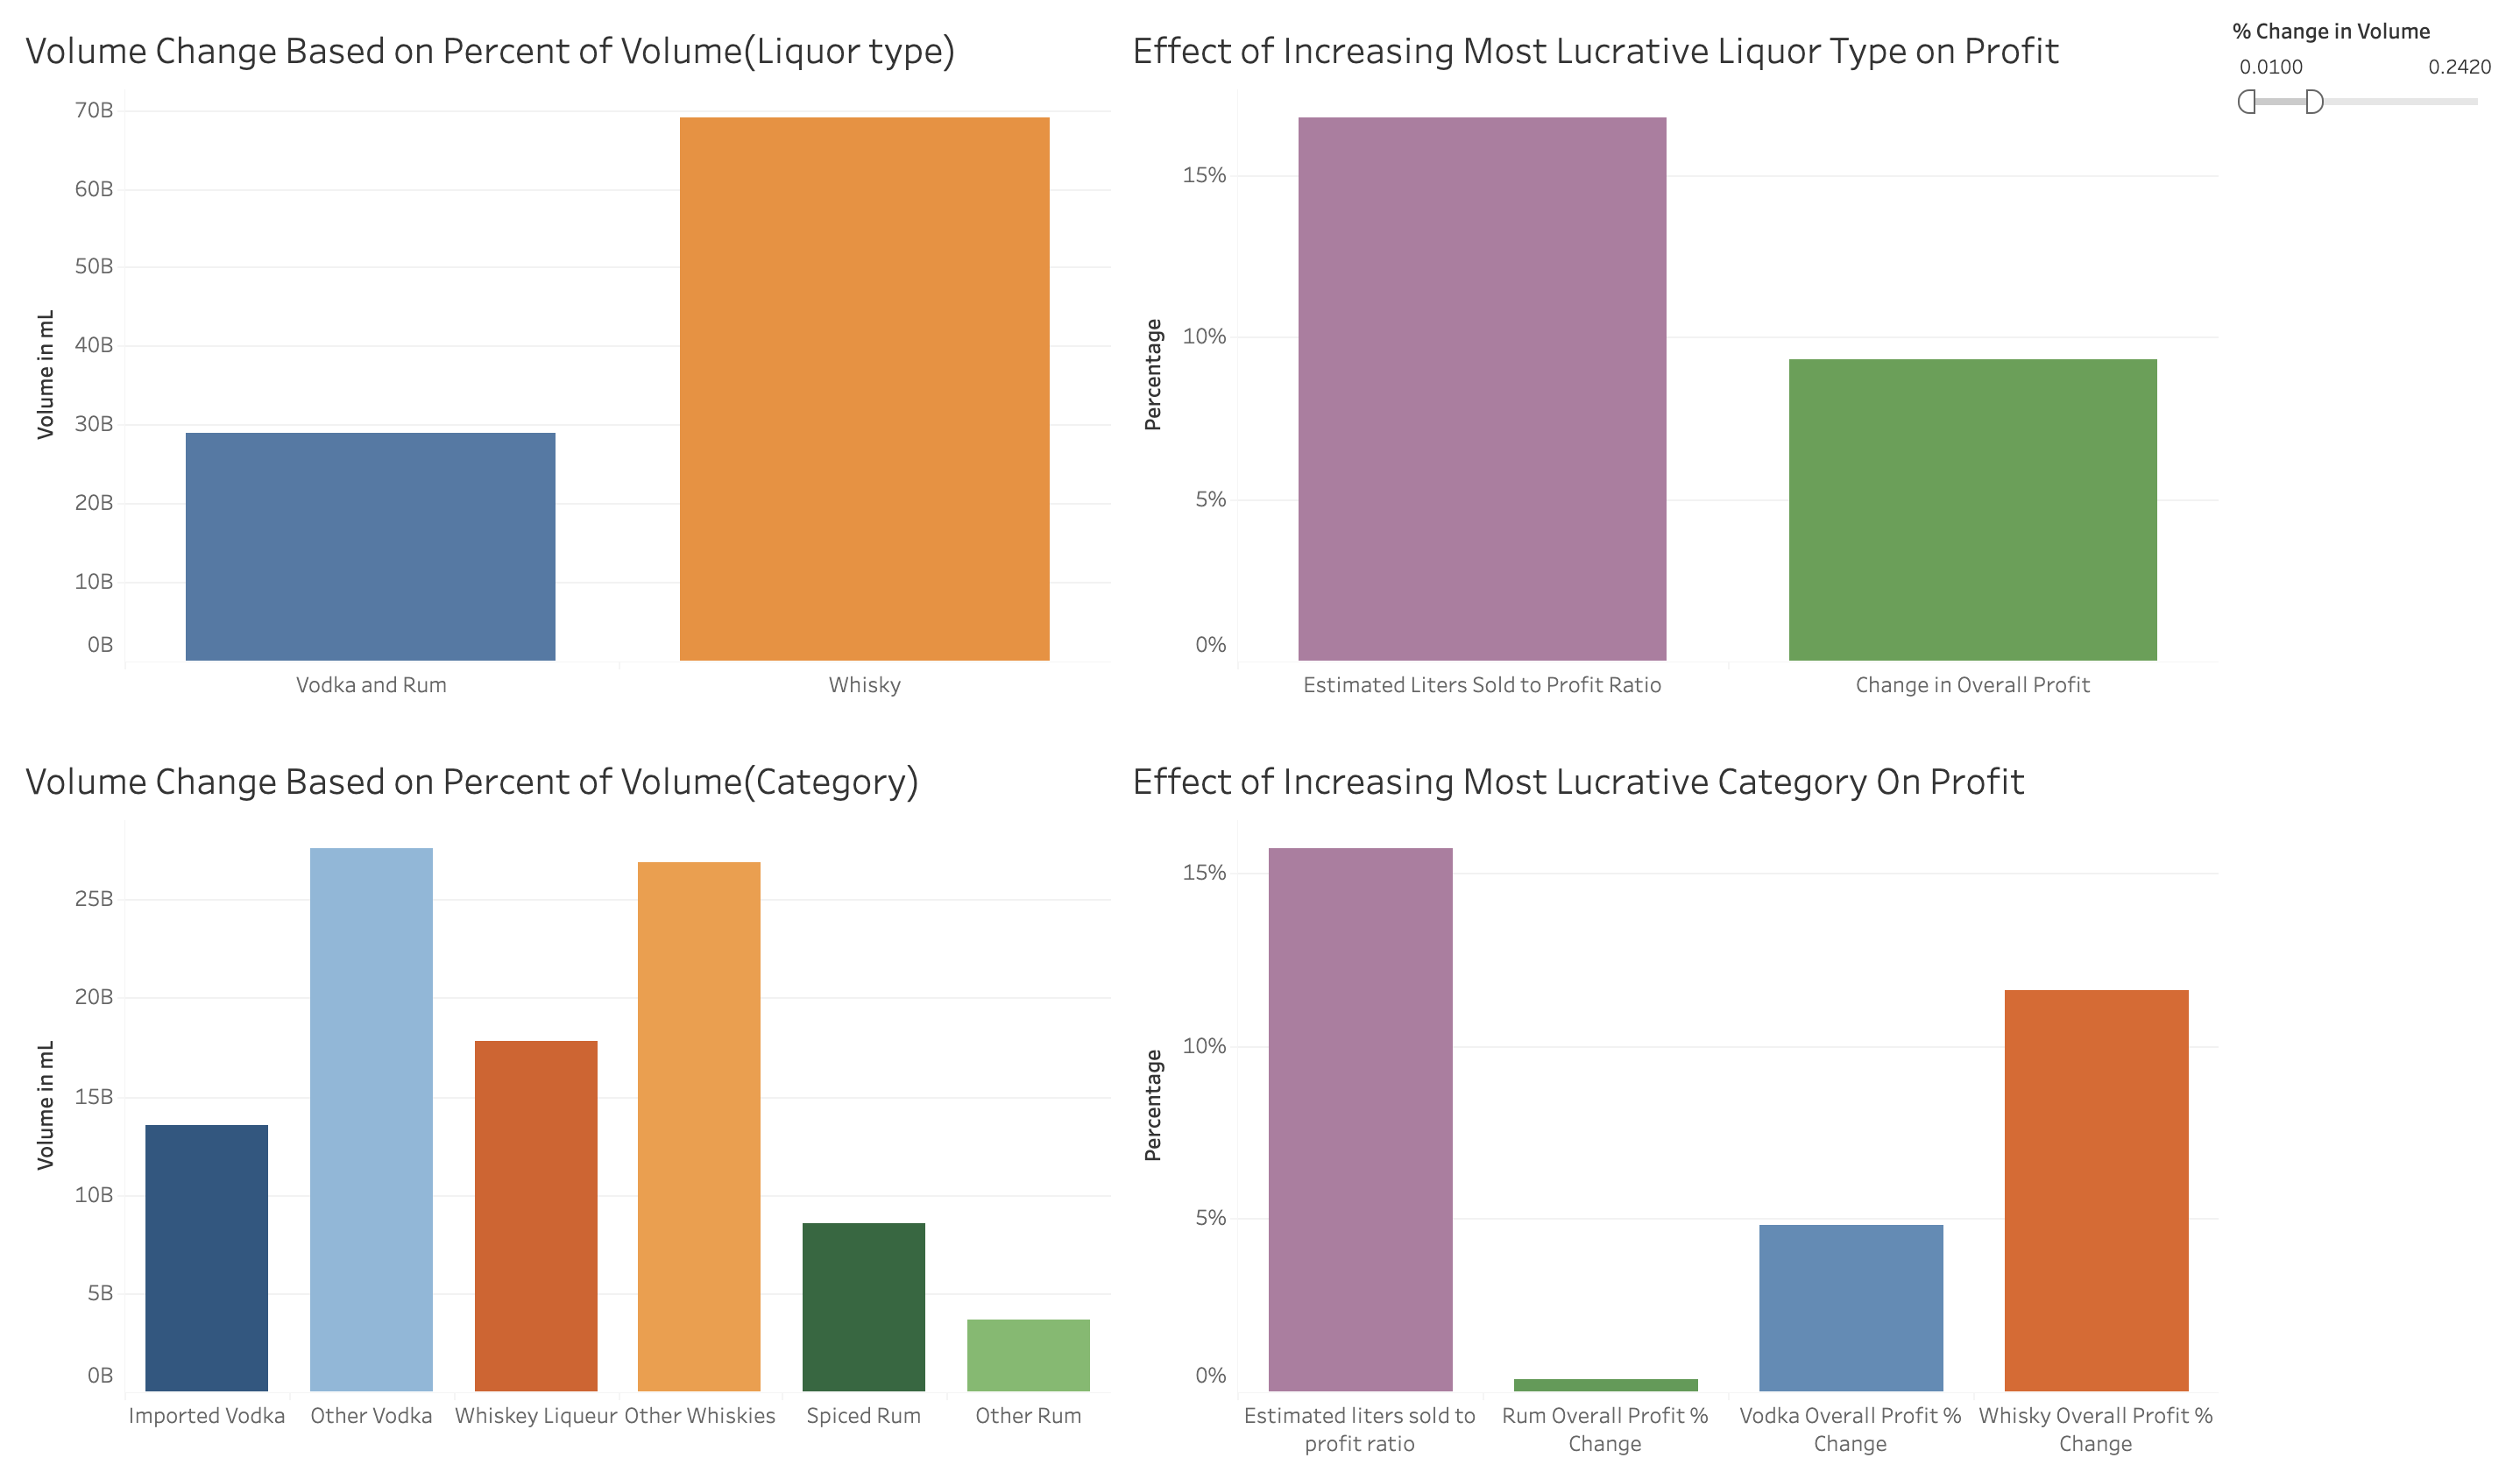

# **Dashboard Materials**
---

## Dashboard Link:

https://public.tableau.com/app/profile/mohammed.alqenae/viz/ImprovingLiquorProfitoftheIowaAlcoholicBeverageDivision/Comparisonofcategories?publish=yes

## Comparison of Categories

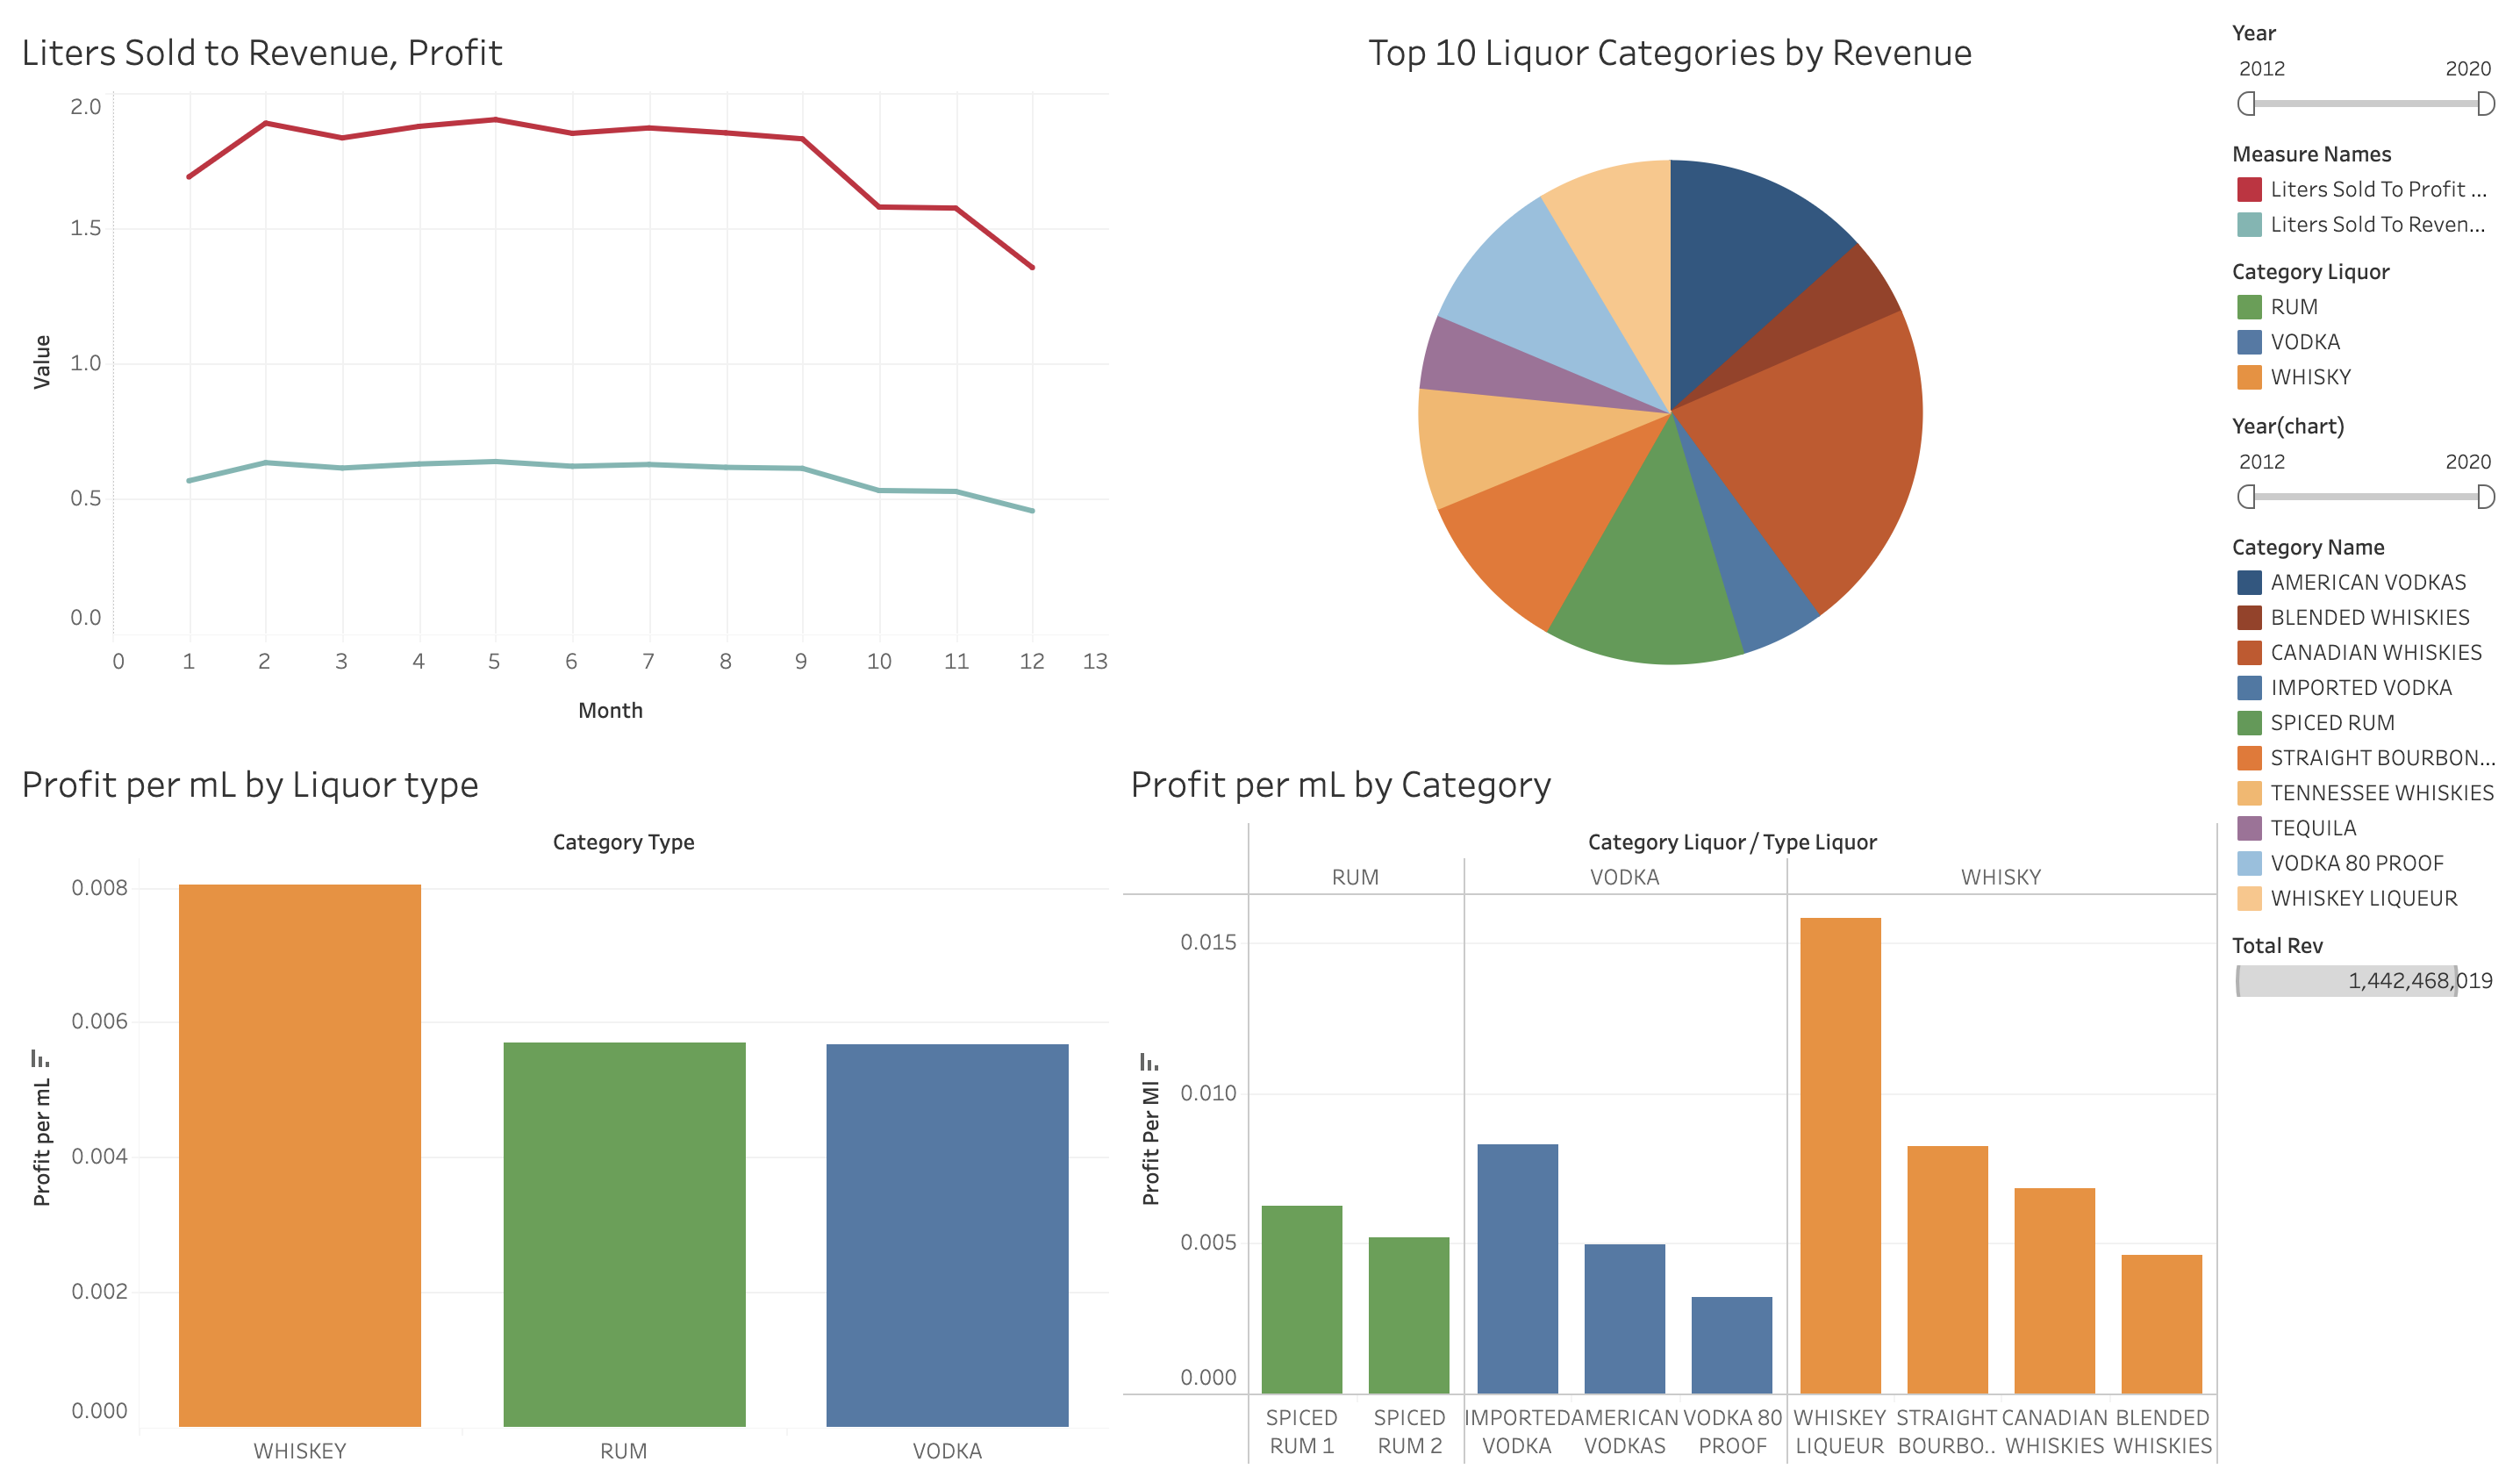

## Effect on Profit 

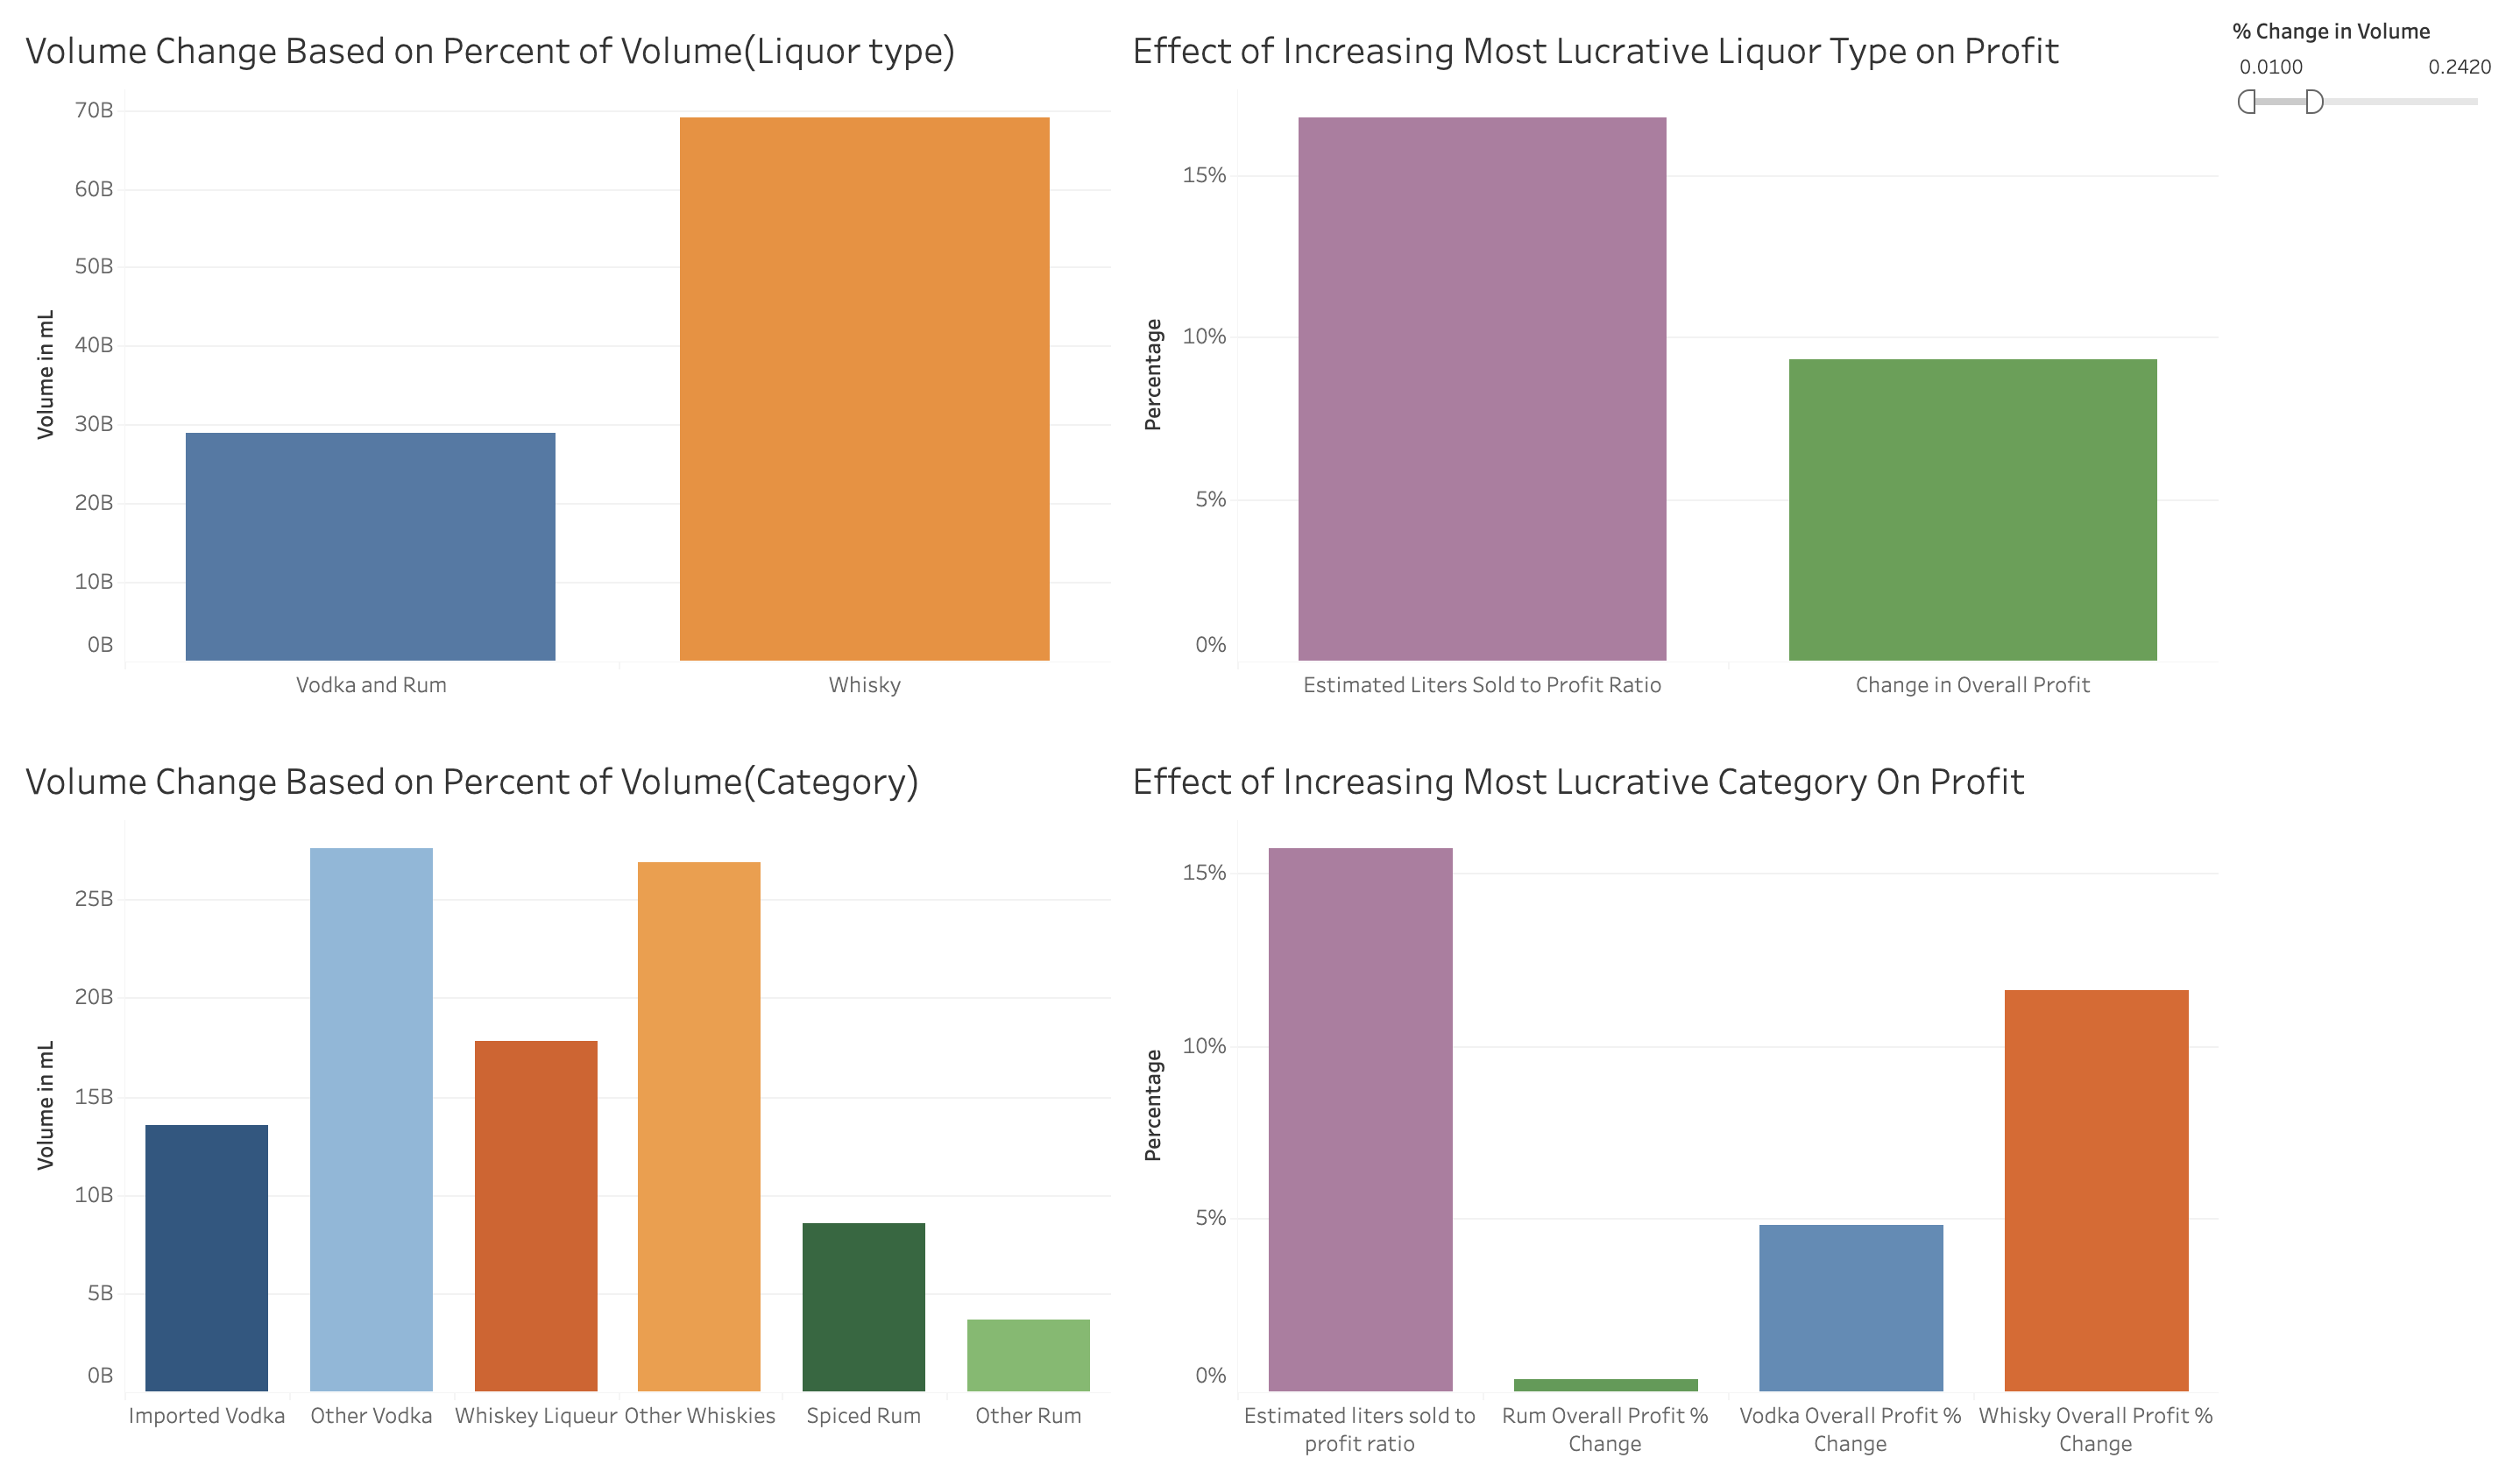

## Store

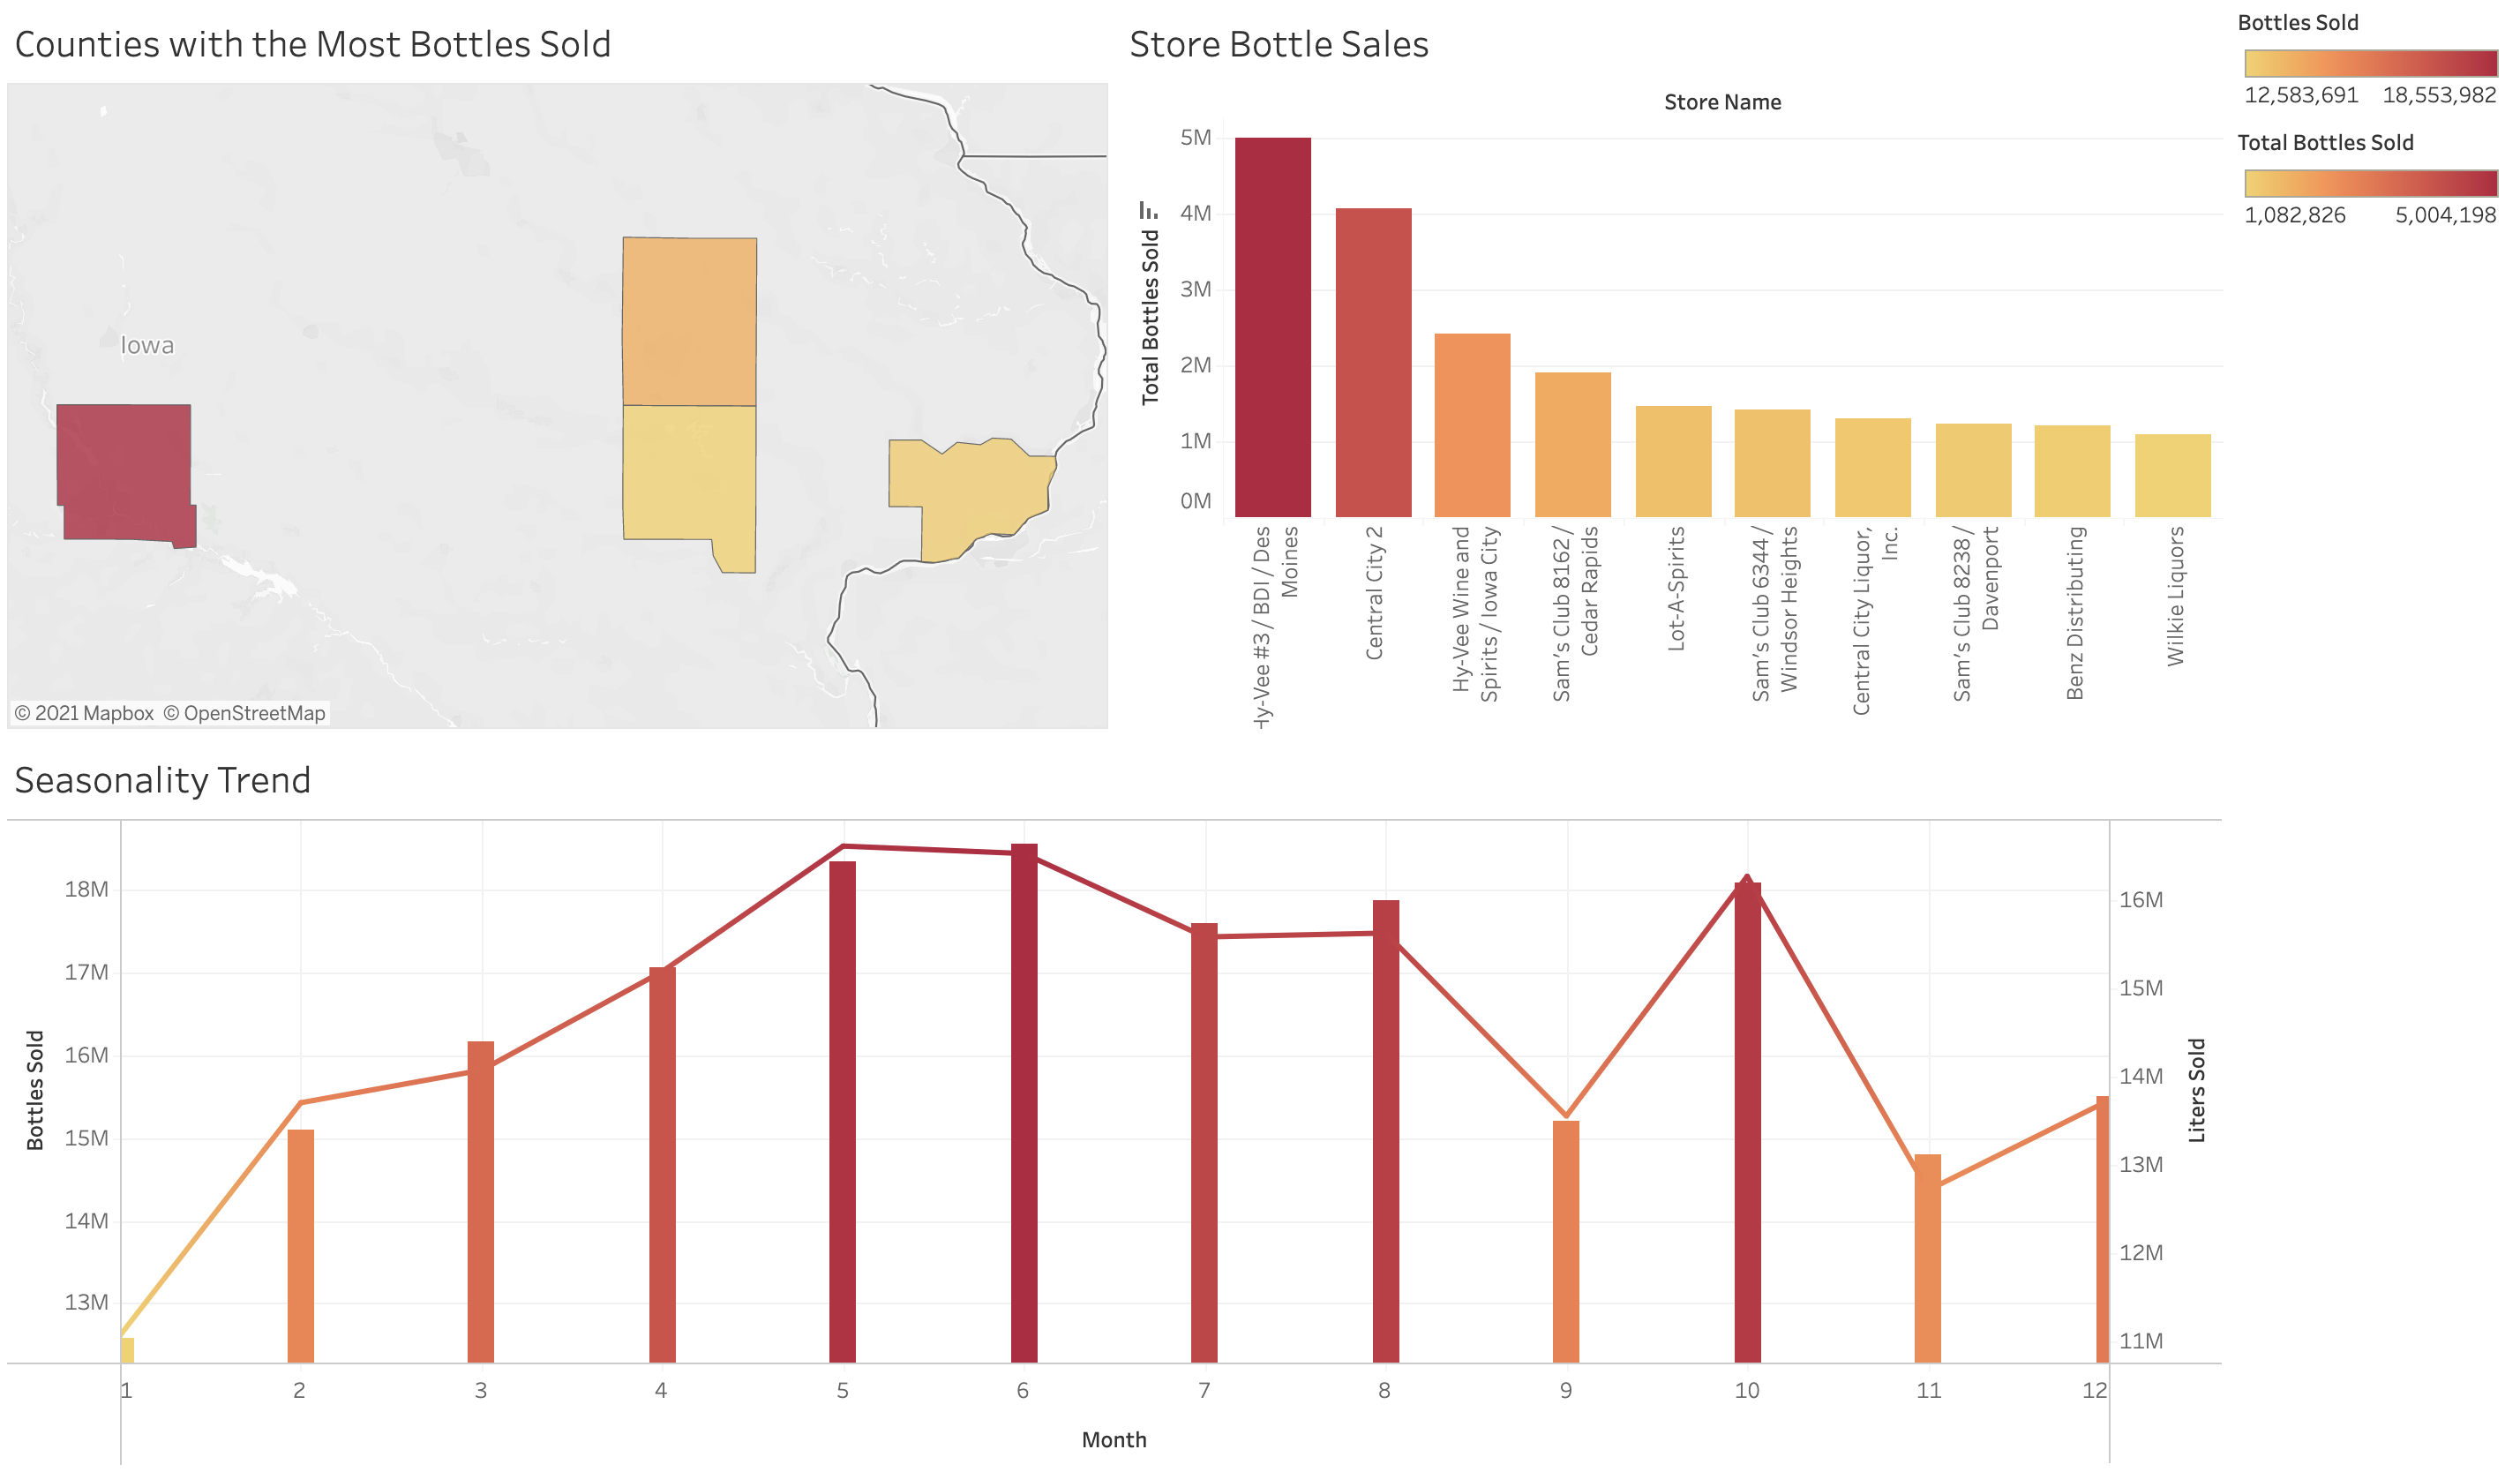

## Vendor


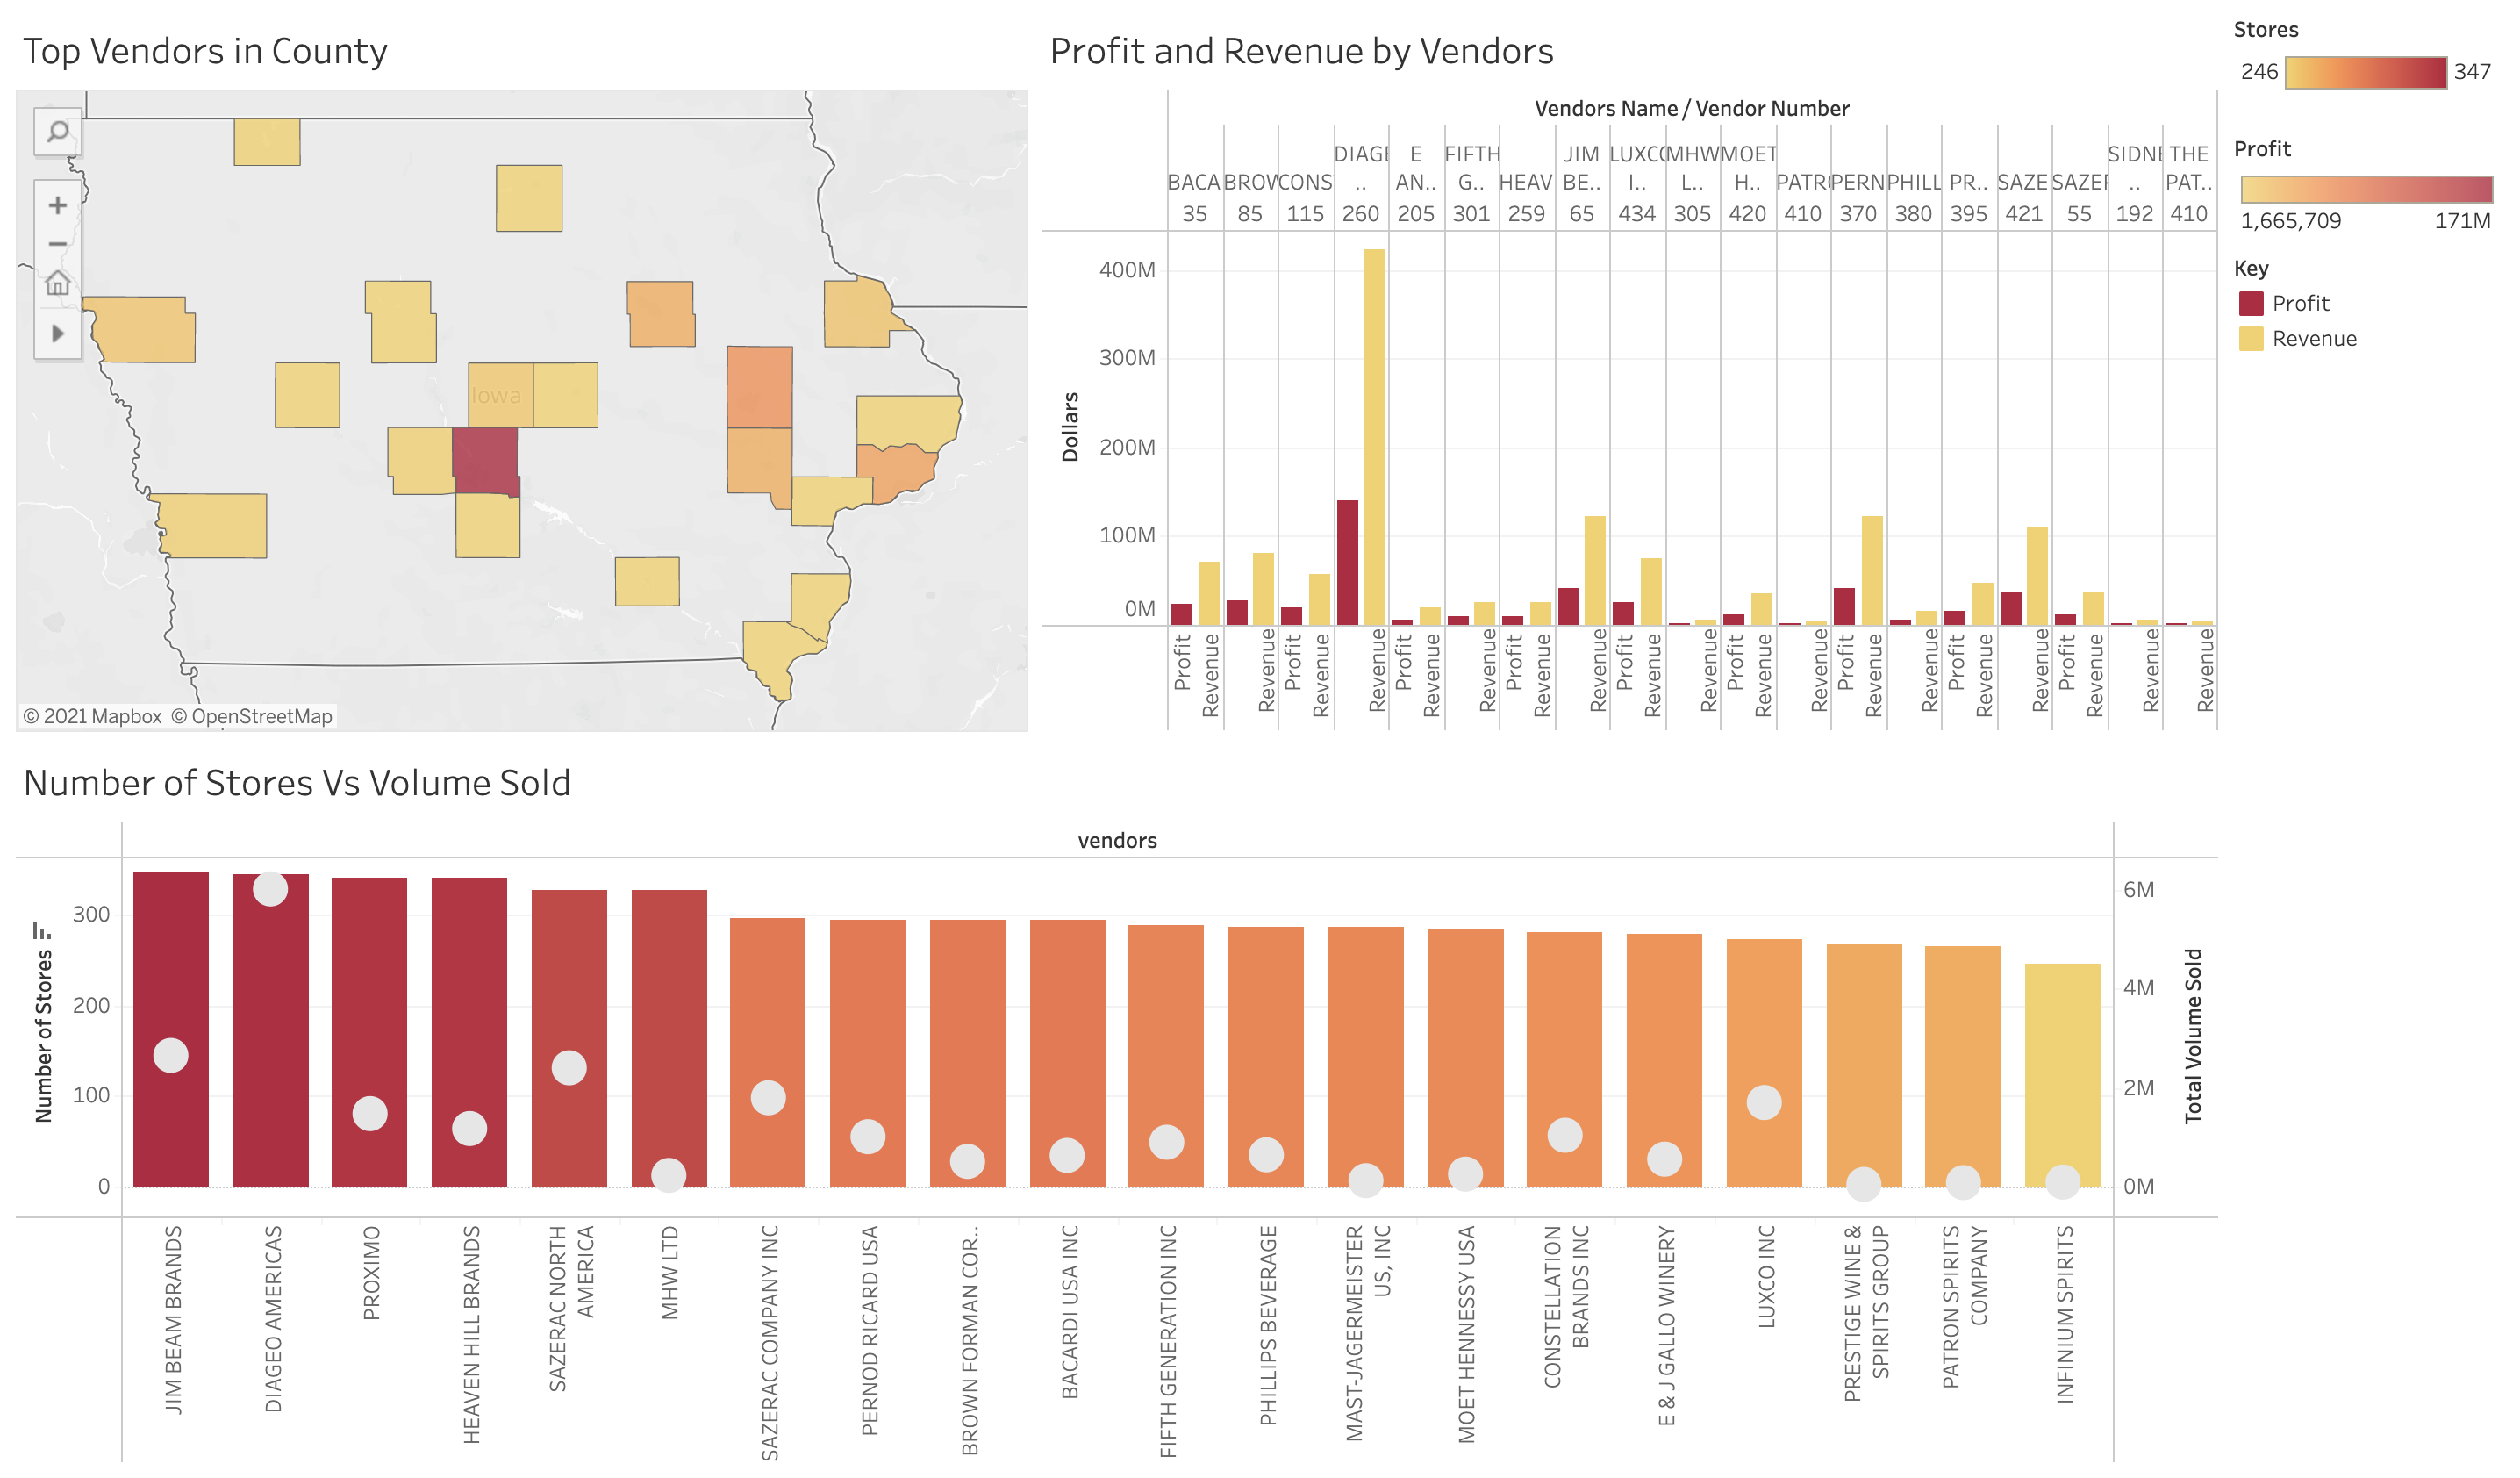